In [5]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import pandas as pd

In [8]:
df = pd.read_csv("daily_csv.csv")
df = df.dropna()
y = df["Price"].values
x = np.arange(1,len(y),1)

In [9]:
minm, maxm = y.min(), y.max()
y = y-minm
y/=maxm-minm

In [10]:
sq = 10

In [12]:
X =[]
Y = []
for i in range(0,5900):
    l1 =[]
    for j in range(i,i+sq):
        l1.append(y[j])
    X.append(l1)
    Y.append(y[j+1])
X = np.array(X)
Y = np.array(Y)

In [13]:
xtrain, xtest, ytrain, ytest = train_test_split(X,Y,test_size = 0.1, random_state=42, shuffle = False, stratify = None)

In [14]:
class TimeSeries(Dataset):
    def __init__(self,x,y):
        self.x = torch.tensor(x, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
        self.len = x.shape[0]
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]
    def __len__(self):
        return self.len
                

In [17]:
dataset = TimeSeries(xtrain,ytrain)
from torch.utils.data import DataLoader
train_loader = DataLoader(dataset,shuffle=True,batch_size=256)

In [31]:
class RNNModel(nn.Module):
    def __init__(self):
        super(RNNModel,self).__init__()
        self.rnn =nn.RNN(input_size=1,hidden_size=5,num_layers=1,batch_first=True)
        self.fc1 = nn.Linear(in_features=5,out_features=1)
    def forward(self,x):
        output,_status = self.rnn(x)
        output = output[:,-1,:]
        output = self.fc1(torch.relu(output))
        return output
device = torch.device("cuda")
model = RNNModel()

In [32]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
epochs = 1500

In [41]:
for i in range(epochs):
    for j, data in enumerate(train_loader):
        y_pred = model(data[:][0].view(-1, sq,
        1)).reshape(-1)
        loss = criterion(y_pred, data[:][1])
        loss.backward()
        optimizer.step()
        if i % 50 == 0:
            print(i, "th iteration : ", loss)

0 th iteration :  tensor(0.0091, grad_fn=<MseLossBackward0>)
0 th iteration :  tensor(0.0084, grad_fn=<MseLossBackward0>)
0 th iteration :  tensor(0.0083, grad_fn=<MseLossBackward0>)
0 th iteration :  tensor(0.0102, grad_fn=<MseLossBackward0>)
0 th iteration :  tensor(0.0072, grad_fn=<MseLossBackward0>)
0 th iteration :  tensor(0.0071, grad_fn=<MseLossBackward0>)
0 th iteration :  tensor(0.0066, grad_fn=<MseLossBackward0>)
0 th iteration :  tensor(0.0067, grad_fn=<MseLossBackward0>)
0 th iteration :  tensor(0.0081, grad_fn=<MseLossBackward0>)
0 th iteration :  tensor(0.0084, grad_fn=<MseLossBackward0>)
0 th iteration :  tensor(0.0087, grad_fn=<MseLossBackward0>)
0 th iteration :  tensor(0.0086, grad_fn=<MseLossBackward0>)
0 th iteration :  tensor(0.0076, grad_fn=<MseLossBackward0>)
0 th iteration :  tensor(0.0081, grad_fn=<MseLossBackward0>)
0 th iteration :  tensor(0.0066, grad_fn=<MseLossBackward0>)
0 th iteration :  tensor(0.0061, grad_fn=<MseLossBackward0>)
0 th iteration :  tensor

KeyboardInterrupt: 

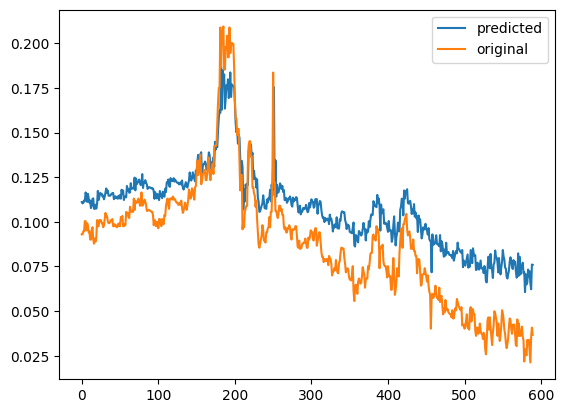

In [45]:
test_set = TimeSeries(xtest,ytest)
test_pred = model(test_set[:][0].view(-1,10,1)).view(-1)
plt.plot(test_pred.detach().numpy(),label='predicted')
plt.plot(test_set[:][1].view(-1),label='original')
plt.legend()
plt.show()


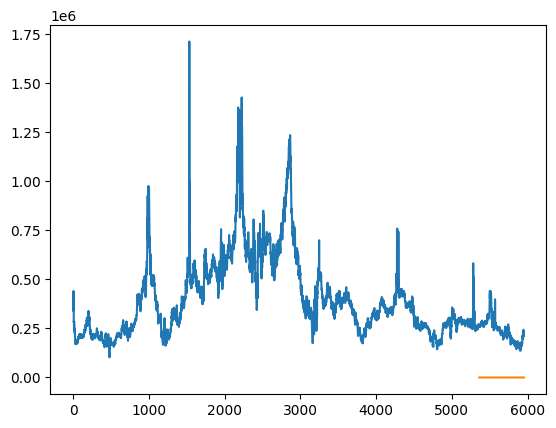

In [46]:
y = y * (maxm - minm) + minm
y_pred = test_pred.detach().numpy() * (maxm - minm) + minm
plt.plot(y)
plt.plot(range(len(y)-len(y_pred), len(y)), y_pred)
plt.show()
